## 基本分类：对服装图像进行分类
将训练一个神经网络模型，对运动鞋和衬衫等服装图像进行分类。使用了 tf.keras，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


### 导入Fashion MNIST 数据集
使用 Fashion MNIST 数据集，该数据集包含 10 个类别的 70,000 个灰度图像。这些图像以低分辨率（28x28 像素）展示了单件衣物，如下所示：

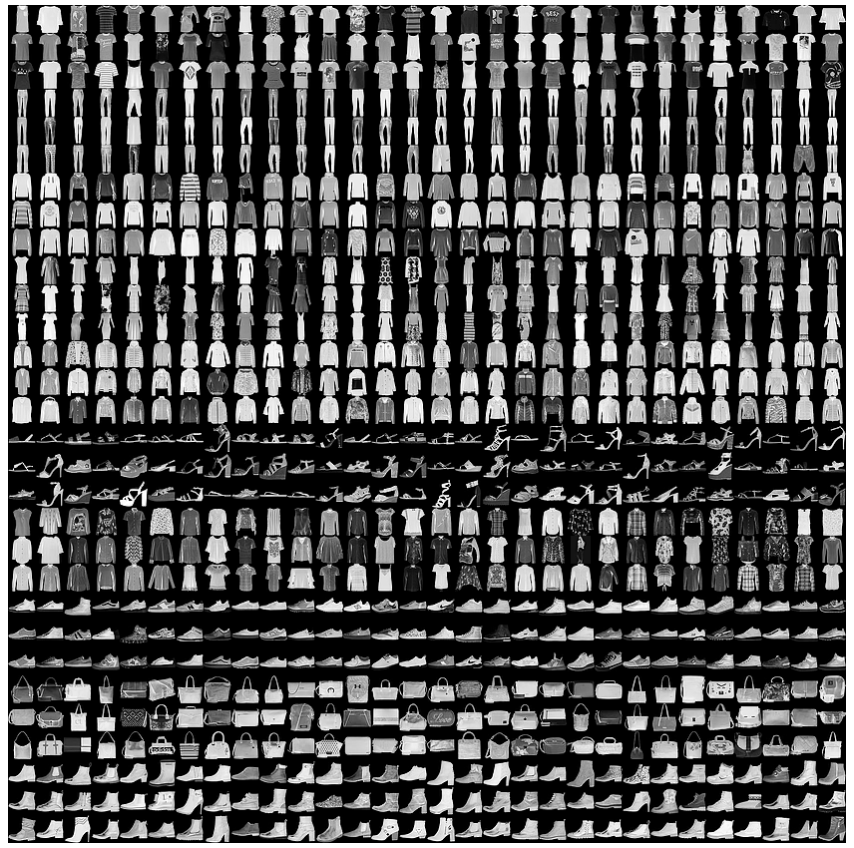

Fashion MNIST 旨在临时替代经典 MNIST 数据集，后者常被用作计算机视觉机器学习程序的“Hello, World”。MNIST 数据集包含手写数字（0、1、2 等）的图像，其格式与您将使用的衣物图像的格式相同。

使用 Fashion MNIST 来实现多样化，因为它比常规 MNIST 更具挑战性。这两个数据集都相对较小，都用于验证某个算法是否按预期工作。对于代码的测试和调试，它们都是很好的起点。

使用 60,000 张图像来训练网络，使用 10,000 张图像来评估网络学习对图像进行分类的准确程度。您可以直接从 TensorFlow 中访问 Fashion MNIST。直接从 TensorFlow 中导入和加载 Fashion MNIST 数据：

In [3]:
# 直接从 TensorFlow 中访问 Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
# 加载数据集
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 0us/step


加载数据集会返回四个 NumPy 数组：
* train_images 和 train_labels 数组是训练集，即模型用于学习的数据。
* 测试集、test_images 和 test_labels 数组会被用来对模型进行测试。

图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。标签是整数数组，介于 0 到 9 之间。这些标签对应于图像所代表的服装类：

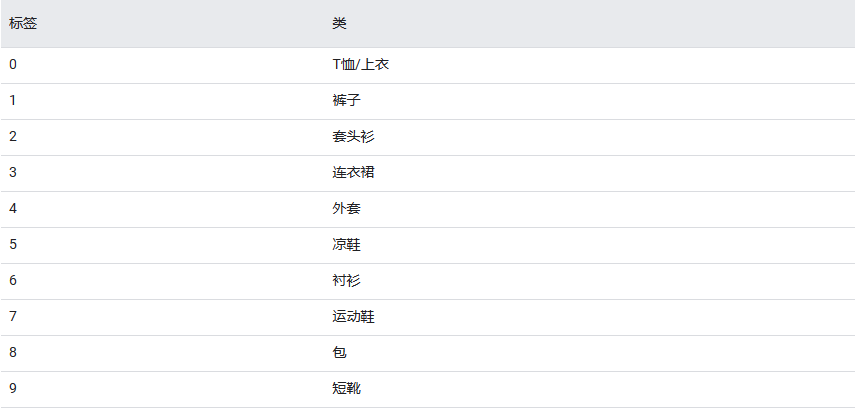

每个图像都会被映射到一个标签。由于数据集不包括类名称，请将它们存储在下方，供稍后绘制图像时使用：

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 浏览数据
在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [5]:
train_images.shape

(60000, 28, 28)

同样，训练集中有 60,000 个标签：

In [6]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [8]:
test_images.shape

(10000, 28, 28)

测试集包含 10,000 个图像标签：

In [9]:
len(test_labels)

10000

### 预处理数据
在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：

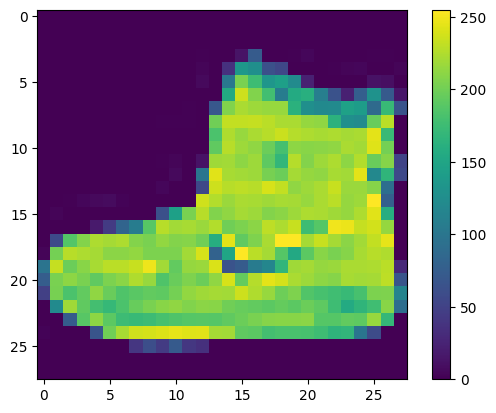

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对训练集和测试集进行预处理：

In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示训练集中的前 25 个图像，并在每个图像下方显示类名称。

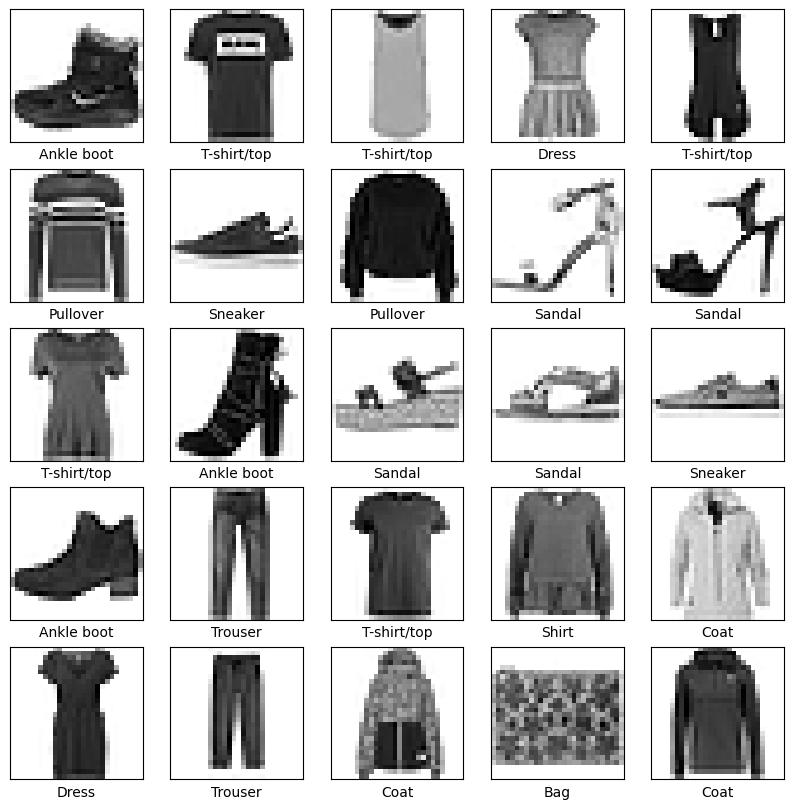

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

---

### 构建模型
构建神经网络需要先配置模型的层，然后再编译模型。

#### 【设置层】
神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。

大多数深度学习都包括将简单的层链接在一起。大多数层（如 tf.keras.layers.Dense）都具有在训练期间才会学习的参数。

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

【说明】：该网络的第一层 tf.keras.layers.Flatten 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 tf.keras.layers.Dense 层的序列。它们是密集连接或全连接神经层。第一个 Dense 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

#### 【编译模型】
在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：
* 损失函数 - 测量模型在训练期间的准确程度。你希望最小化此函数，以便将模型“引导”到正确的方向上。
* 优化器 - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
* 指标 - 用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [15]:
model.compile(optimizer='adam', # 优化器
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
              metrics=['accuracy']) # 指标

---

### 训练模型
训练神经网络模型需要执行以下步骤：
* 将训练数据馈送给模型。在本例中，训练数据位于 train_images 和 train_labels 数组中。
* 模型学习将图像和标签关联起来。
* 要求模型对测试集（在本例中为 test_images 数组）进行预测。
* 验证预测是否与 test_labels 数组中的标签相匹配。



#### 【向模型馈送数据】
开始训练，调用 model.fit 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 747us/step - loss: 0.4952 - accuracy: 0.8244
Epoch 2/10
1875/1875 [==============================] - 1s 718us/step - loss: 0.3704 - accuracy: 0.8656
Epoch 3/10
1875/1875 [==============================] - 1s 764us/step - loss: 0.3341 - accuracy: 0.8784
Epoch 4/10
1875/1875 [==============================] - 1s 742us/step - loss: 0.3107 - accuracy: 0.8868
Epoch 5/10
1875/1875 [==============================] - 1s 718us/step - loss: 0.2924 - accuracy: 0.8933
Epoch 6/10
1875/1875 [==============================] - 1s 731us/step - loss: 0.2783 - accuracy: 0.8972
Epoch 7/10
1875/1875 [==============================] - 1s 720us/step - loss: 0.2672 - accuracy: 0.9013
Epoch 8/10
1875/1875 [==============================] - 1s 755us/step - loss: 0.2562 - accuracy: 0.9039
Epoch 9/10
1875/1875 [==============================] - 1s 727us/step - loss: 0.2455 - accuracy: 0.9079
Epoch 10/10
1875/1875 [==============================] - 1s 718u

在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

#### 【评估准确率】
接下来，比较模型在测试数据集上的表现：

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3218 - accuracy: 0.8894

Test accuracy: 0.8894000053405762


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表过拟合。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。

#### 【进行预测】
模型经过训练后，您可以使用它对一些图像进行预测。附加一个 Softmax 层，将模型的线性输出 logits 转换成更容易理解的概率。

In [19]:
# 附加Softmax层
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [20]:
# 预测
predictions = probability_model.predict(test_images)

In [21]:
# 查看预测结果
predictions[0]

array([9.0960604e-08, 4.1643644e-10, 3.3383341e-09, 5.6918487e-10,
       5.3392891e-11, 6.0615462e-04, 2.1039686e-08, 1.1128897e-02,
       2.4652476e-07, 9.8826456e-01], dtype=float32)

【说明】：预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。可以看到哪个标签的置信度值最大：

In [23]:
# argmax返回的是最大数的索引
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 class_names[9]。通过检查测试标签发现这个分类是正确的：

In [24]:
test_labels[0]

9

---

### 使用训练好的模型进行预测


In [25]:
img = test_images[1]

print(img.shape)

(28, 28)


In [26]:
# 将图像添加到批处理中（为了和上面test_image格式一样）
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [27]:
# 进行预测
predictions_single = probability_model.predict(img)

print(predictions_single)

[[8.0349081e-04 3.4045219e-13 9.9428117e-01 3.1606501e-08 2.7402549e-03
  2.0760132e-12 2.1750561e-03 1.1371979e-18 1.5070551e-09 5.9368108e-11]]


In [28]:
# 输出结果
np.argmax(predictions_single[0])

2

### 参考
https://www.tensorflow.org/tutorials/keras/classification?hl=zh-cn